# Model3 LSTM

An LSTM (Long Short-Term Memory) is a type of artificial neural network that can remember patterns or sequences over a long period of time. Imagine you're trying to understand a story that someone is telling you, word by word. To make sense of the story, you need to remember not just the current word but also the words that came before it. This is similar to what an LSTM does.

Think of an LSTM as a series of connected "memory cells," each cell responsible for remembering a part of the sequence. As information passes through these cells, they can "learn" which parts are important and should be remembered, and which parts can be forgotten. This is useful when dealing with data that has a time component, like speech, music, or a series of text messages.

![3](<https://raw.githubusercontent.com/jh4578/5293finalproject/main/_build/html/_images/LSTM3.webp>)

![2](<https://raw.githubusercontent.com/jh4578/5293finalproject/main/_build/html/_images/LSTM2.webp>)

Although it looks complex, you will easily understand it with one example. 
Suppose we are going to take a sequence of exams: high school math --> Calculus --> Linear Algebra --> … At this point, we just finished our high school math exam, and we are studying for the Calculus exam. 
 
The memory we have right now is $C_{t-1}$ in the left corner, it includes plenty of knowledge related to high school math. $h_{t-1}$ in the left bottom represents ourselves, $X_t$ represents the textbooks of Calculus. 

When we read the Calculus textbooks ($h_{t-1}$ and $X_t$ merge), we realized that some of our memory is irrelevant to Calculus, such as geometry. Since our memory space is limited, we need to forget that irrelevant knowledge, which is shown by the forget gate $f_t$. 
 
Then we discover some Calculus information, and we need to memorize it. Again, since our memory space is limited, we don’t want to learn knowledge irrelevant to the exam, such as the history of Calculus. That’s what the yellow tanh and $i_t$ do. $i_t$ takes charge of learning knowledge, while tanh filters the relevant knowledge. 
 
Finally, we are going to take the exam. In the exam, we need to grab specific knowledge (not all knowledge) from our memory to solve specific questions. That’s how the red tanh work, it filters our memory and grabs specific knowledge. After we finished the exam, we will receive an output score h_t in the upper right corner. We can use that score to check how good is our study process. Also, we will pass our memory $C_t$ to the next cell. 

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/jh4578/5293finalproject/main/GOOG.csv',date_parser = True)

In [ ]:
data.index = data['Date']
data.drop(columns = ['Date','Volume'], inplace = True)


In [ ]:
data.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133
2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639
2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787
2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960
2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104


In [ ]:
data[:'2019'].iloc[:,0:1].values

array([[ 2.490664],
       [ 2.51582 ],
       [ 2.758411],
       ...,
       [50.857498],
       [52.480999],
       [52.548   ]])

Here we define a function organize train and test data set. We will use the data from 2004 to 2019 to train the model and the other used for test. 

In [ ]:
time_step_in = 5
time_step_out = 2

# Split training and testing data
data_train = data[:'2019'].iloc[:,0:1].values
data_test = data['2019':].iloc[:,0:1].values
data_value = data.iloc[:,0:1].values

# Scale the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_sc = sc.fit_transform(data_value)

# Create X_train and y_train 
X_train = []
y_train = []
for i in range(time_step_in,len(data_train) - time_step_out - 1):
  X_train.append(data_sc[i - time_step_in:i, 0])
  y_train.append(data_sc[i:i + time_step_out,0])


X_train, y_train = np.array(X_train), np.array(y_train)
# We can take a look at the X_train and y_train
#print(pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis = 1))

X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

X_test = []
# Create X_test
for i in range(len(data_train) - time_step_out - 1, len(data_sc) - time_step_out - 1 ):
  X_test.append(data_sc[i - time_step_in:i,0])
X_test = np.array(X_test)
print(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

[[0.32952688 0.32421874 0.32327155 0.30941549 0.31447262]
 [0.32421874 0.32327155 0.30941549 0.31447262 0.32389072]
 [0.32327155 0.30941549 0.31447262 0.32389072 0.33475804]
 ...
 [0.69226473 0.69126067 0.6884493  0.67291979 0.67104555]
 [0.69126067 0.6884493  0.67291979 0.67104555 0.66247755]
 [0.6884493  0.67291979 0.67104555 0.66247755 0.66428484]]


In [ ]:
def actual_pred_plot(preds):
    actual_pred = pd.DataFrame(columns = ['Open', 'prediction'])
    actual_pred['Open'] = data.loc['2019':,'Open'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Open']),np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot() )
    

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


34/34 [==============================] - 1s 2ms/step


(501.4106, <Axes: xlabel='Date'>)

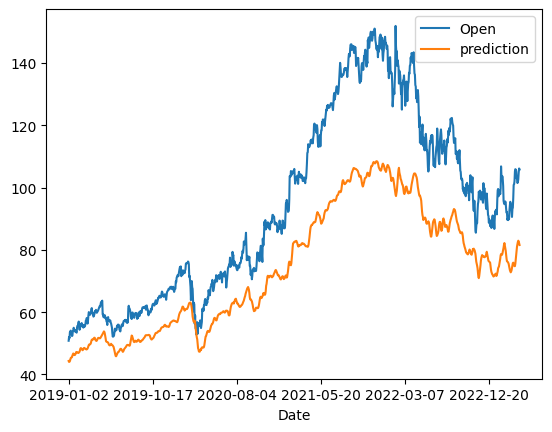

In [ ]:
def LSTM_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dense(units=2))

    # Compiling
    my_LSTM_model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction


my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
actual_pred_plot(LSTM_prediction) 

In [ ]:
LSTM_prediction

array([[44.33528 , 45.61733 ],
       [44.03457 , 45.28942 ],
       [44.087112, 45.33005 ],
       ...,
       [82.689186, 86.69119 ],
       [82.15135 , 86.11352 ],
       [81.55466 , 85.46417 ]], dtype=float32)

The prediction looks great, BUT that is because every predictions I made was based on real data, not the predicted data. 

If I want to predict the stock without the real data (we cannot get real data for stock in future), I need to use the Recursive Multi-step Forecast Strategy.

In [ ]:
# predict with the test data
input_sequence = X_test[0].reshape(1, time_step_in, 1)
# Initialize an empty list to store predictions
predictions = []

for i in range(len(X_test)):
    # Predict the next time_step_out points using the current input_sequence
    pred = my_LSTM_model.predict(input_sequence)
    
    # Add the predicted points to the predictions list
    predictions.extend(pred[0])
    
    # Update the input_sequence by adding the predicted points and removing the first time_step_out points
    input_sequence = np.roll(input_sequence, -time_step_out)
    input_sequence[0, -time_step_out:] = pred.reshape(-1,1)

# Inverse transform the predictions
predictions = sc.inverse_transform(np.array(predictions).reshape(-1, 1))
plt.plot(predictions)